# Module 2: Epidemic Modeling Template

## Team Members:
Asma Sanaullah & Melis Ozdemir

## Project Title:
*(Fill in)*

## Project Goal:
This project seeks to... *(what is the purpose of your project -- i.e., describe the question that you seek to answer by analyzing data.)*

## 1. Data and disease background
You can fill out this section throughout the module as you uncover more information about the mystery disease.

By the end of the module (when submitting), you should have some information about each of the following points:
* Prevalence & incidence in the UVA population
* Economic burden (you can generalize from respiratory viruses)
* Symptoms
* Biological mechanisms (anatomy, organ physiology, cell & molecular physiology - you can generalize from viral biology)


## 2. Data Analysis
This section should be filled out sequentially as a full report of the work you've done over this module. You can copy and paste code from any main.py file here, and run it to produce plots. Once you gain more information throughout the module, you do not need to go back and "fix" earlier results. In other words, if your early predictions are found to be wrong when gaining new data, do not go back and rewrite them.

### 2a. Methods

*IN A SUMMARY, DESCRIBE THE METHODS YOU USED TO ANALYZE AND MODEL THE DATA.*


<div style="
    border-left: 6px solid #fbc02d;
    background-color: #fff8e1;
    padding: 10px 15px;
    border-radius: 4px;
">
<b style="color:#f57f17;">ANALYSIS AFTER DATA RELEASE #1</b> 

</div>



### 2b. Plot the data & estimate initial growth rate (R0) from early data (through day 45)
This section should come from your python code after Data Release #1.

#### Plot the DATA RELEASE #1 data: day vs. active infections

Using CSV at: C:\Users\Asma Sanaullah\OneDrive - University of Virginia\Spring 2026\COMP BME\Module-2-Epidemics-SIR-Modeling\Code\mystery_virus_daily_active_counts_RELEASE#1.csv


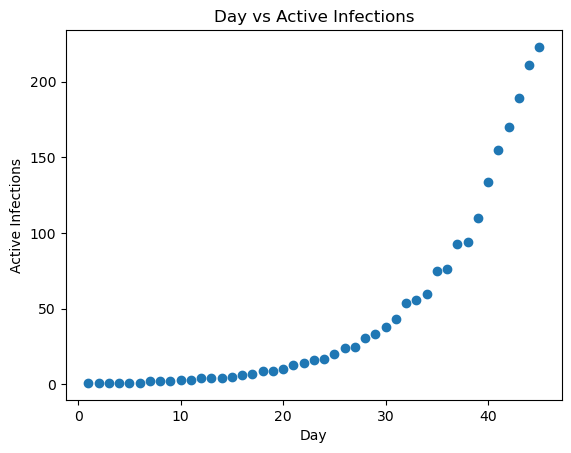

In [14]:
#import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os

# Read the CSV file
HERE = Path(os.getcwd())

# CSV is in the Code folder
csv_path = HERE.parent / "Code" / "mystery_virus_daily_active_counts_RELEASE#1.csv"

print("Using CSV at:", csv_path.resolve())

# Check if CSV exists
if not csv_path.exists():
    raise FileNotFoundError(
        f"Could not find CSV at: {csv_path.resolve()}\n"
        "Make sure the CSV is in the Code folder."
    )

# Load CSV
df = pd.read_csv(csv_path)

# Create scatterplot
plt.scatter(df['day'], df['active reported daily cases'])

# Plot labels and titles
plt.title('Day vs Active Infections')
plt.xlabel('Day')
plt.ylabel('Active Infections')

# Display the plot
plt.show()

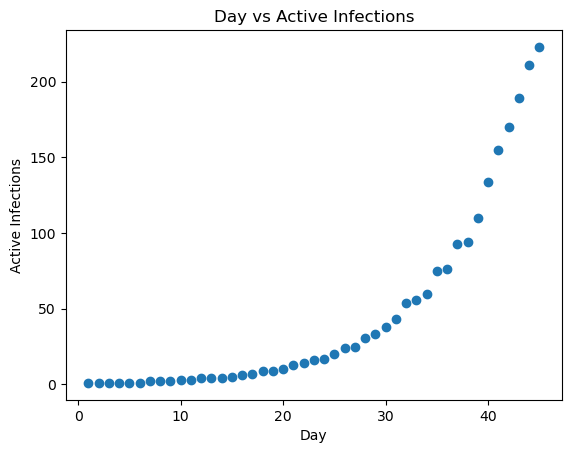

QUESTIONS TO ANSWER:


What do you notice about the initial infections?

The initial infections grow very slowly, with the curve nearly flat at the beginning. This indicates that only a small number of people are infected early on, making the outbreak appear minor at first.


How could we measure how quickly its spreading?

The speed of spread can be measured by how much the number of infections increases each day, such as the slope of the curve or the time it takes for cases to double. A steeper slope means the virus is spreading faster.


What information about the virus would be helpful in determining the shape of the outbreak curve?

Helpful information includes how contagious the virus is, how long the incubation and infectious periods are, and how people behave in response to the outbreak. These factors strongly influence how quickly the curve rises and its overall shape.

#### Estimate R0 for the mystery virus data using a fit to the exponential growth in I

Using CSV at: C:\Users\Asma Sanaullah\OneDrive - University of Virginia\Spring 2026\COMP BME\Module-2-Epidemics-SIR-Modeling\Code\mystery_virus_daily_active_counts_RELEASE#1.csv
Best exponential window: day 22 to 35 (length 14)
Fit on log(I): R^2 = 0.9942
Growth rate r: 0.1281 per day
Doubling time: 5.41 days
Assumed infectious period D: 5.0 days
Estimated R0 ≈ 1 + r*D = 1.640


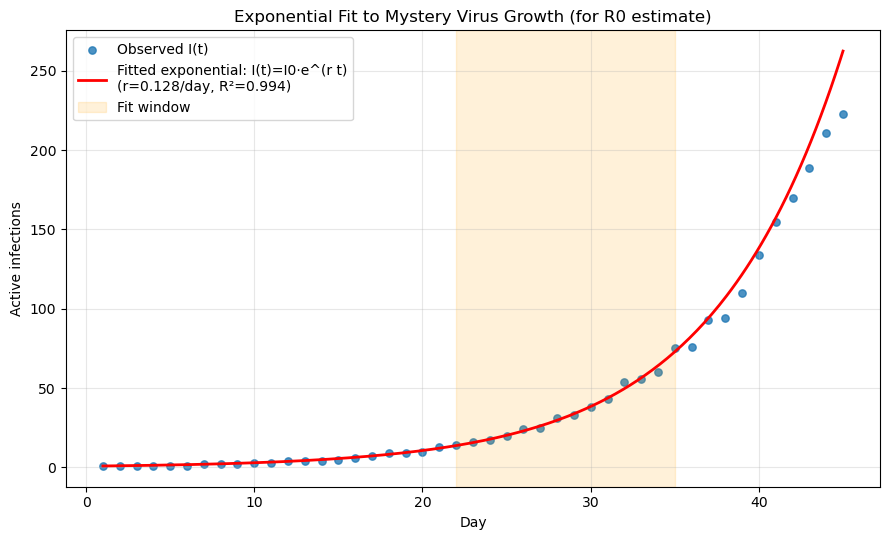

In [18]:
#estimate_R0_mystery_virus

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os

# - Settings  -
infectious_period_days = 5.0
min_window = 7
max_window = 14


HERE = Path(os.getcwd())

# CSV is in the Code folder
csv_path = HERE.parent / "Code" / "mystery_virus_daily_active_counts_RELEASE#1.csv"

print("Using CSV at:", csv_path.resolve())

# Check if CSV exists
if not csv_path.exists():
    raise FileNotFoundError(
        f"Could not find CSV at: {csv_path.resolve()}\n"
        "Make sure the CSV is in the Code folder, one level up from this notebook."
    )

# Load CSV
df = pd.read_csv(csv_path)


# Standardize column names (lowercase, replace spaces with underscores)
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# We expect: 'day' and 'active_reported_daily_cases'
expected = {"day", "active_reported_daily_cases"}
if not expected.issubset(df.columns):    
    raise KeyError(        
        f"Expected columns {sorted(expected)}, but found {list(df.columns)}.\n"        
        "Update the column mapping below if names differ."    
    )
# Extract day and I(t)
t = df["day"].astype(float).to_numpy()
I = df["active_reported_daily_cases"].astype(float).to_numpy()

# Guard against nonpositive I values (log undefined)
if np.any(I <= 0):    
    # Replace zeros (if any) by a tiny positive value for logging;   
    # or you can drop those rows if preferred.    
    I = np.where(I <= 0, 1e-6, I)

# - Helper to fit a window and return r, I0, r2
def fit_exp_window(tw, Iw):    
    """    
    Fit log(I) = r * t + log(I0).    
    Returns r, I0, r2 (R-squared on log-scale).    
    """    
    logI = np.log(Iw)    
    # Linear fit: slope r, intercept logI0    
    r, logI0 = np.polyfit(tw, logI, 1)    
    # Compute R^2 on log-scale    
    logI_pred = r * tw + logI0    
    ss_res = np.sum((logI - logI_pred) ** 2)    
    ss_tot = np.sum((logI - np.mean(logI)) ** 2)    
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan    
    I0 = np.exp(logI0)    
    return r, I0, r2

# - Search for the most exponential-looking window
best = None  # (r2, r, I0, t_start, t_end)
n = len(t)

for w in range(min_window, max_window + 1):    
    for i in range(0, n - w + 1):        
        tw = t[i:i+w]        
        Iw = I[i:i+w]        
        # Avoid all-constant segments in log-space        
        if np.allclose(Iw, Iw[0]):            
            continue        
        r, I0, r2 = fit_exp_window(tw, Iw)        
        if np.isnan(r2):            
            continue        
        if (best is None) or (r2 > best[0]):            
            best = (r2, r, I0, int(tw[0]), int(tw[-1]))
        
if best is None:    
    raise RuntimeError("Could not find a suitable exponential window. Check your data.")

best_r2, r, I0, t_start, t_end = best

# - Compute R0 and doubling time
doubling_time = np.log(2) / r if r > 0 else np.inf
R0 = 1.0 + r * infectious_period_days

print(f"Best exponential window: day {t_start} to {t_end} (length {t_end - t_start + 1})")
print(f"Fit on log(I): R^2 = {best_r2:.4f}")
print(f"Growth rate r: {r:.4f} per day")
print(f"Doubling time: {doubling_time:.2f} days")
print(f"Assumed infectious period D: {infectious_period_days} days")
print(f"Estimated R0 ≈ 1 + r*D = {R0:.3f}")

# - Plot: scatter all data + fitted exponential curve
t_fit = np.linspace(t.min(), t.max(), 300)
I_fit = I0 * np.exp(r * t_fit)

plt.figure(figsize=(9, 5.5))
plt.scatter(t, I, s=28, alpha=0.8, label="Observed I(t)")
plt.plot(t_fit, I_fit, 'r', lw=2.0, label=f"Fitted exponential: I(t)=I0·e^(r t)\n(r={r:.3f}/day, R²={best_r2:.3f})")


# Shade the selected window
plt.axvspan(t_start, t_end, color="orange", alpha=0.15, label="Fit window")
plt.xlabel("Day")
plt.ylabel("Active infections")
plt.title("Exponential Fit to Mystery Virus Growth (for R0 estimate)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


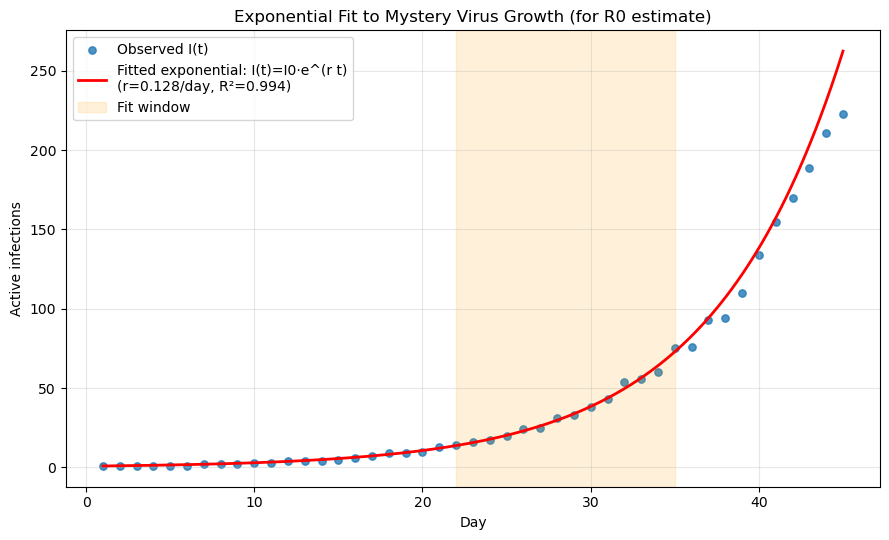

Estimated R0 ≈ 1 + r*D = 1.640

What viruses have a similar R0? Use the viruses.html file to find a virus or 2 with a similar R0 and give a 1-2 sentence background of the diseases.


How accurate do you think your R0 estimate is?


<div style="
    border-left: 6px solid #fbc02d;
    background-color: #fff8e1;
    padding: 10px 15px;
    border-radius: 4px;
">
<b style="color:#f57f17;">ANALYSIS AFTER DATA RELEASE #2</b> 

</div>



### 2c. Use Euler's method to solve the SEIR model.
This section should come from your python code after Data Release #2.

### 2d. Fit the SEIR model to the data by changing beta, gamma, and sigma.
This section should come from your python code after Data Release #2.

### 2e. Plot the model-predicted infections over time compared to the data.
This section should come from your python code after Data Release #2.

### 2e. Predict the day and amount of active cases at the peak of the epidemic spread.
This section should come from your python code after Data Release #2.



<div style="
    border-left: 6px solid #fbc02d;
    background-color: #fff8e1;
    padding: 10px 15px;
    border-radius: 4px;
">
<b style="color:#f57f17;">ANALYSIS AFTER DATA RELEASE #3</b> 

</div>



### 2f. Plot the full dataset (Data Release #3) against your model.
This section should come from your python code after Data Release #3.


### 2g. Intervention strategies for new outbreak at VT (70 days of infection)
This section should come from your python code after Data Release #3.



## Verify and validate your analysis: 

*(Describe how you checked to see that your analysis gave you an answer that you believe (verify). Describe how your determined if your analysis gave you an answer that is supported by other evidence (e.g., a published paper).*

## Conclusions and Ethical Implications: 
*(Think about the answer your analysis generated, draw conclusions related to your overarching question, and discuss the ethical implications of your conclusions.*

## Limitations and Future Work: 
*(Think about the answer your analysis generated, draw conclusions related to your overarching question, and discuss the ethical implications of your conclusions.*